In [23]:
import seaborn as sns
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from faker import Faker

import numpy as np
import pandas as pd
from faker import Faker
import matplotlib.pyplot as plt

# Initialize Faker
fake = Faker()
Faker.seed(42)

# Define products and time periods
products = ['Analytics', 'MachineLearning', 'WebHosting', 'IoT', 'Serverless']
time_periods = 6  # e.g., 6 months of data

# Create distinct customer types
customer_types = [
    {'name': 'Stable', 'size': 'Medium', 'spend_range': (10000, 50000), 'growth_range': (-0.05, 0.05)},
    {'name': 'Growing', 'size': 'Small', 'spend_range': (5000, 20000), 'growth_range': (0.1, 0.5)},
    {'name': 'Declining', 'size': 'Large', 'spend_range': (30000, 100000), 'growth_range': (-0.3, -0.1)},
    {'name': 'Shifting', 'size': 'Medium', 'spend_range': (15000, 70000), 'growth_range': (-0.2, 0.2)}
]

def generate_customer_data(n_customers):
    data = []
    for customer_id in range(1, n_customers + 1):
        customer_type = np.random.choice(customer_types)
        customer_base = {
            'CustomerID': customer_id,
            'CompanyName': fake.company(),
            'CompanySize': customer_type['size'],
            'CustomerType': customer_type['name']
        }
        
        # Generate data for each time period
        for period in range(time_periods):
            customer = customer_base.copy()
            customer['TimePeriod'] = period
            customer['TotalSpend'] = np.random.randint(*customer_type['spend_range'])
            
            # Generate product usage and growth
            total_growth = 0
            for product in products:
                if period == 0:
                    # Initial usage
                    customer[f'{product}_Usage'] = np.random.randint(0, 1000)
                    customer[f'{product}_Growth'] = 0  # No growth for the first period
                else:
                    # Find the previous period's data for this customer
                    prev_customer_data = next(item for item in reversed(data) if item['CustomerID'] == customer_id and item['TimePeriod'] == period - 1)
                    prev_usage = prev_customer_data[f'{product}_Usage']
                    
                    # Calculate new usage based on previous usage
                    change = np.random.uniform(*customer_type['growth_range'])
                    customer[f'{product}_Usage'] = max(0, int(prev_usage * (1 + change)))
                    
                    # Calculate growth
                    customer[f'{product}_Growth'] = (customer[f'{product}_Usage'] - prev_usage) / prev_usage if prev_usage > 0 else 0
                    total_growth += customer[f'{product}_Growth']
            
            # Determine customer status
            if period > 0:
                customer['TotalGrowth'] = total_growth / len(products)
                new_product_adoption = any(customer[f'{product}_Usage'] > 0 and prev_customer_data[f'{product}_Usage'] == 0 for product in products)
                significant_shift = abs(customer['TotalGrowth']) > 0.2
                
                if customer_type['name'] == 'Declining' and customer['TotalGrowth'] < -0.1 and not new_product_adoption:
                    customer['Status'] = 'Red Flag'
                elif new_product_adoption or (customer_type['name'] == 'Shifting' and significant_shift):
                    customer['Status'] = 'Shifting'
                elif customer['TotalGrowth'] > 0.1:
                    customer['Status'] = 'Growing'
                elif customer['TotalGrowth'] < -0.05:
                    customer['Status'] = 'Declining'
                else:
                    customer['Status'] = 'Stable'
            else:
                customer['Status'] = 'New'
                customer['TotalGrowth'] = 0
            
            data.append(customer)
    
    return pd.DataFrame(data)

# Generate data
n_customers = 1000
df = generate_customer_data(n_customers)
df


,CustomerID,CompanyName,CompanySize,CustomerType,TimePeriod,TotalSpend,Analytics_Usage,Analytics_Growth,MachineLearning_Usage,MachineLearning_Growth,WebHosting_Usage,WebHosting_Growth,IoT_Usage,IoT_Growth,Serverless_Usage,Serverless_Growth,Status,TotalGrowth
0,1,"Rodriguez, Figueroa and Sanchez",Medium,Shifting,0,27305,959,0.000000,716,0.000000,656,0.000000,380,0.000000,712,0.000000,New,0.000000
1,1,"Rodriguez, Figueroa and Sanchez",Medium,Shifting,1,51156,886,-0.076121,711,-0.006983,612,-0.067073,438,0.152632,764,0.073034,Stable,0.015098
2,1,"Rodriguez, Figueroa and Sanchez",Medium,Shifting,2,40303,985,0.111738,570,-0.198312,723,0.181373,432,-0.013699,760,-0.005236,Stable,0.015173
3,1,"Rodriguez, Figueroa and Sanchez",Medium,Shifting,3,23050,868,-0.118782,537,-0.057895,842,0.164592,348,-0.194444,745,-0.019737,Stable,-0.045253
4,1,"Rodriguez, Figueroa and Sanchez",Medium,Shifting,4,39381,869,0.001152,487,-0.093110,767,-0.089074,403,0.158046,819,0.099329,Stable,0.015269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1000,Stokes Group,Medium,Shifting,1,23102,804,-0.171988,185,-0.119048,471,-0.083658,148,-0.069182,123,-0.039062,Declining,-0.096588
5996,1000,Stokes Group,Medium,Shifting,2,65241,819,0.018657,203,0.097297,379,-0.195329,128,-0.135135,118,-0.040650,Declining,-0.051032
5997,1000,Stokes Group,Medium,Shifting,3,47441,797,-0.026862,242,0.192118,374,-0.013193,120,-0.062500,134,0.135593,Stable,0.045031
5998,1000,Stokes Group,Medium,Shifting,4,34189,933,0.170640,270,0.115702,382,0.021390,124,0.033333,137,0.022388,Stable,0.072691


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       159
           1       1.00      1.00      1.00        41

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Confusion Matrix:
[[159   0]
 [  0  41]]


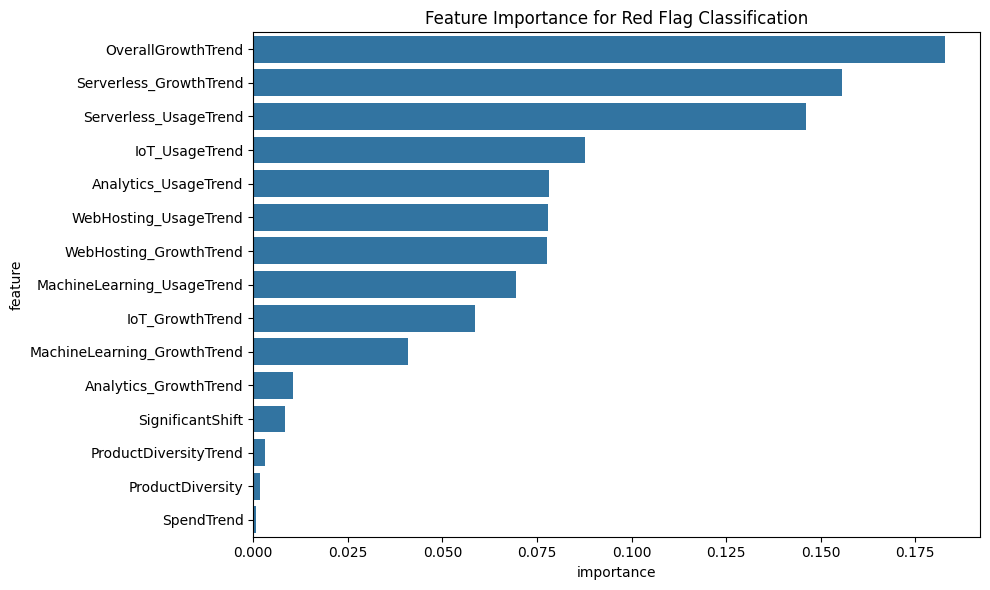


Analysis of Misclassified Customers:
       OverallGrowthTrend  ProductDiversityTrend  SignificantShift  RedFlag
count                 0.0                    0.0               0.0      0.0
mean                  NaN                    NaN               NaN      NaN
std                   NaN                    NaN               NaN      NaN
min                   NaN                    NaN               NaN      NaN
25%                   NaN                    NaN               NaN      NaN
50%                   NaN                    NaN               NaN      NaN
75%                   NaN                    NaN               NaN      NaN
max                   NaN                    NaN               NaN      NaN

Business Insights:
1. Out of 1000 customers, 233 (23.30%) are classified as Red Flag.
2. The model's accuracy in identifying Red Flag customers is 100.00%.
3. The top 3 indicators of a Red Flag customer are: OverallGrowthTrend, Serverless_GrowthTrend, Serverless_UsageTrend.
4.

In [24]:

# Feature engineering
def engineer_features(df):
    features = df.copy()
    
    # Calculate product-specific metrics
    for product in products:
        features[f'{product}_GrowthTrend'] = features.groupby('CustomerID')[f'{product}_Growth'].transform(lambda x: x.mean())
        features[f'{product}_UsageTrend'] = features.groupby('CustomerID')[f'{product}_Usage'].transform(lambda x: x.pct_change().mean())
    
    # Calculate overall metrics
    features['OverallGrowthTrend'] = features.groupby('CustomerID')['TotalGrowth'].transform(lambda x: x.mean())
    features['SpendTrend'] = features.groupby('CustomerID')['TotalSpend'].transform(lambda x: x.pct_change().mean())
    
    # Calculate product diversity
    features['ProductDiversity'] = features[[f'{product}_Usage' for product in products]].gt(0).sum(axis=1)
    features['ProductDiversityTrend'] = features.groupby('CustomerID')['ProductDiversity'].transform(lambda x: x.diff().mean())
    
    # Identify significant shifts
    features['SignificantShift'] = ((features['OverallGrowthTrend'].abs() > 0.2) | (features['ProductDiversityTrend'] > 0)).astype(int)
    
    return features

# Prepare data for modeling
features = engineer_features(df)
features = features.groupby('CustomerID').last().reset_index()  # Use the latest data point for each customer

# Define target variable
features['RedFlag'] = ((features['Status'] == 'Red Flag') & (features['OverallGrowthTrend'] < -0.1) & (features['SignificantShift'] == 0)).astype(int)

# Select features for the model
feature_cols = [f'{product}_GrowthTrend' for product in products] + [f'{product}_UsageTrend' for product in products] + ['OverallGrowthTrend', 'SpendTrend', 'ProductDiversity', 'ProductDiversityTrend', 'SignificantShift']

X = features[feature_cols]
y = features['RedFlag']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred = clf.predict(X_test_scaled)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': clf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Red Flag Classification')
plt.tight_layout()
plt.show()

# Analysis of misclassifications
misclassified = features[features.index.isin(X_test.index[y_test != y_pred])]
print("\nAnalysis of Misclassified Customers:")
print(misclassified[['CustomerType', 'CompanySize', 'OverallGrowthTrend', 'ProductDiversityTrend', 'SignificantShift', 'RedFlag']].describe())

# Business insights
print("\nBusiness Insights:")
print(f"1. Out of {len(features)} customers, {features['RedFlag'].sum()} ({features['RedFlag'].mean():.2%}) are classified as Red Flag.")
print(f"2. The model's accuracy in identifying Red Flag customers is {classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']:.2%}.")
print(f"3. The top 3 indicators of a Red Flag customer are: {', '.join(feature_importance['feature'].head(3).tolist())}.")
print("4. Customers with significant shifts in product usage or growth are less likely to be classified as Red Flag, indicating potential positive changes in their IT infrastructure.")

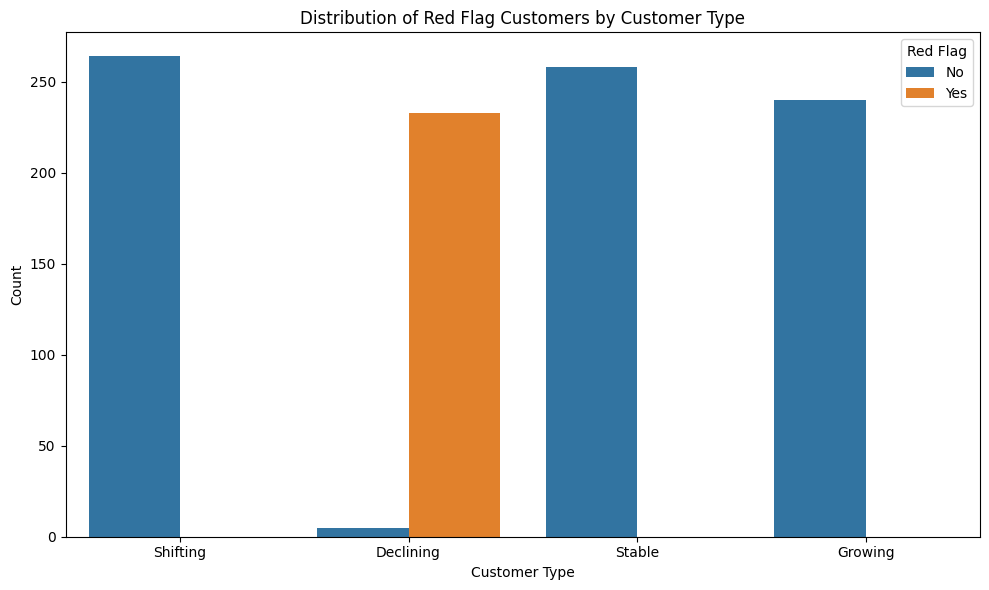

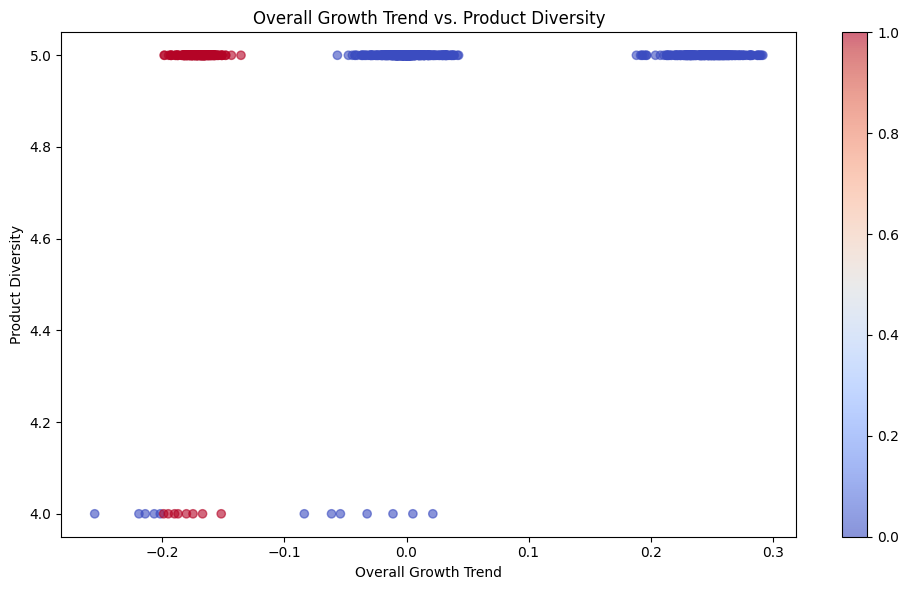


Top 10 Declining Customers:

Customer ID: 242
Company: Larson-Holloway
Type: Declining
Overall Growth Trend: -25.55%
Product Diversity: 4
Product Usage:
  - Analytics: 1 (Growth: -29.17%)
  - MachineLearning: 14 (Growth: -19.71%)
  - WebHosting: 229 (Growth: -16.96%)
  - IoT: 0 (Growth: -40.28%)
  - Serverless: 30 (Growth: -21.62%)

Customer ID: 277
Company: Cook-Hines
Type: Declining
Overall Growth Trend: -21.92%
Product Diversity: 4
Product Usage:
  - Analytics: 200 (Growth: -16.80%)
  - MachineLearning: 0 (Growth: -40.28%)
  - WebHosting: 53 (Growth: -18.99%)
  - IoT: 214 (Growth: -16.79%)
  - Serverless: 151 (Growth: -16.75%)

Customer ID: 998
Company: Nelson-Johnson
Type: Declining
Overall Growth Trend: -21.40%
Product Diversity: 4
Product Usage:
  - Analytics: 263 (Growth: -16.88%)
  - MachineLearning: 0 (Growth: -40.28%)
  - WebHosting: 194 (Growth: -20.58%)
  - IoT: 45 (Growth: -15.91%)
  - Serverless: 391 (Growth: -13.36%)

Customer ID: 42
Company: George Group
Type: Declinin

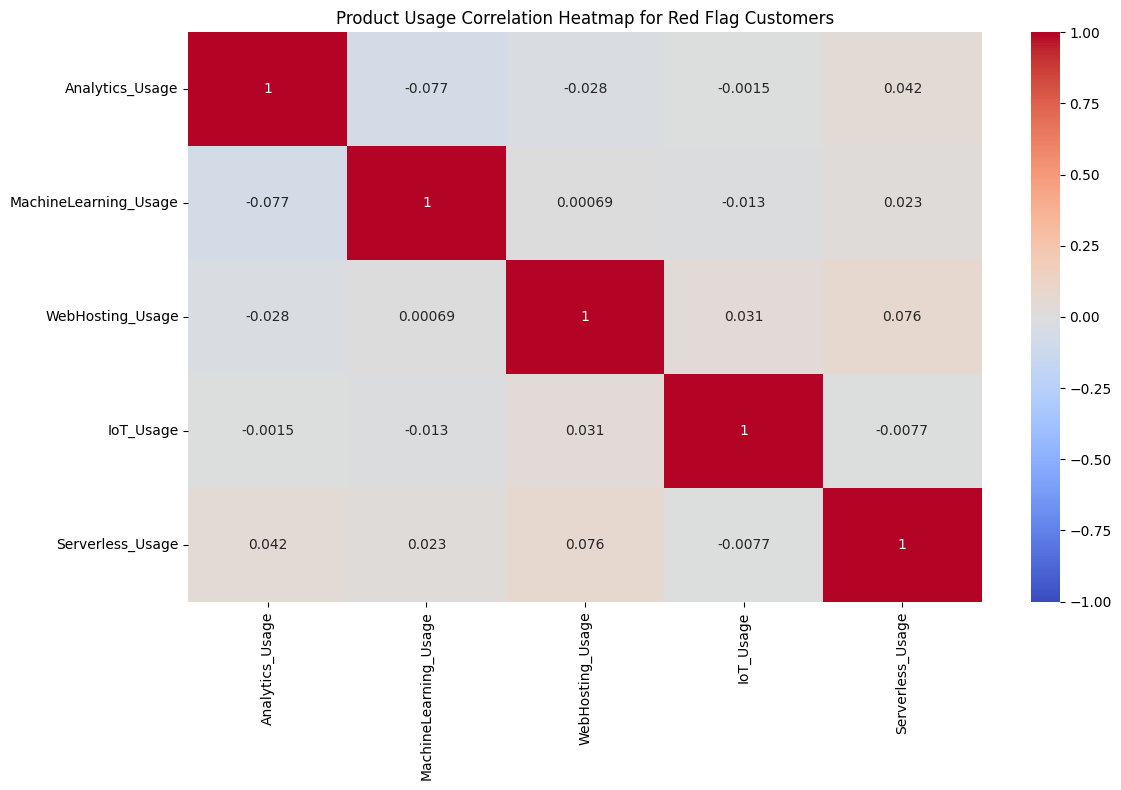


Additional Business Insights:
1. Average product diversity for red flag customers: 4.97
2. Most common customer type among red flags: Declining
3. Percentage of red flags with significant shifts: 0.00%

Common Patterns in Declining Customers:
CustomerType  OverallGrowthTrend  SpendTrend  ProductDiversityTrend  SignificantShift
   Declining           -0.170862    0.113575              -0.006009               0.0

Recommendations:
1. Focus on diversifying product offerings for customers with low product diversity.
2. Investigate reasons for decline in the most common red flag customer type.
3. Develop targeted retention strategies for customers showing early signs of decline.
4. Regularly monitor for significant shifts in usage patterns to identify potential turnaround opportunities.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# [Previous code for data generation and initial analysis remains the same]
# ...

# After running the initial analysis, add these new functions and visualizations:

def plot_red_flag_distribution(features):
    plt.figure(figsize=(10, 6))
    sns.countplot(x='CustomerType', hue='RedFlag', data=features)
    plt.title('Distribution of Red Flag Customers by Customer Type')
    plt.xlabel('Customer Type')
    plt.ylabel('Count')
    plt.legend(title='Red Flag', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

def plot_growth_vs_diversity(features):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(features['OverallGrowthTrend'], features['ProductDiversity'], 
                          c=features['RedFlag'], cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter)
    plt.title('Overall Growth Trend vs. Product Diversity')
    plt.xlabel('Overall Growth Trend')
    plt.ylabel('Product Diversity')
    plt.tight_layout()
    plt.show()

def analyze_top_decliners(features, n=10):
    top_decliners = features.sort_values('OverallGrowthTrend').head(n)
    
    print(f"\nTop {n} Declining Customers:")
    for _, customer in top_decliners.iterrows():
        print(f"\nCustomer ID: {customer['CustomerID']}")
        print(f"Company: {customer['CompanyName']}")
        print(f"Type: {customer['CustomerType']}")
        print(f"Overall Growth Trend: {customer['OverallGrowthTrend']:.2%}")
        print(f"Product Diversity: {customer['ProductDiversity']}")
        print("Product Usage:")
        for product in products:
            print(f"  - {product}: {customer[f'{product}_Usage']:.0f} (Growth: {customer[f'{product}_GrowthTrend']:.2%})")

def plot_product_usage_heatmap(features):
    usage_cols = [f'{product}_Usage' for product in products]
    usage_data = features[features['RedFlag'] == 1][usage_cols]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(usage_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Product Usage Correlation Heatmap for Red Flag Customers')
    plt.tight_layout()
    plt.show()

# Run the new visualizations and analysis
plot_red_flag_distribution(features)
plot_growth_vs_diversity(features)
analyze_top_decliners(features)
plot_product_usage_heatmap(features)

# Additional business insights
red_flag_customers = features[features['RedFlag'] == 1]

print("\nAdditional Business Insights:")
print(f"1. Average product diversity for red flag customers: {red_flag_customers['ProductDiversity'].mean():.2f}")
print(f"2. Most common customer type among red flags: {red_flag_customers['CustomerType'].mode().values[0]}")
print(f"3. Percentage of red flags with significant shifts: {(red_flag_customers['SignificantShift'] == 1).mean():.2%}")

# Identify common patterns in declining customers
declining_patterns = red_flag_customers.groupby('CustomerType').agg({
    'OverallGrowthTrend': 'mean',
    'SpendTrend': 'mean',
    'ProductDiversityTrend': 'mean',
    'SignificantShift': 'mean'
}).reset_index()

print("\nCommon Patterns in Declining Customers:")
print(declining_patterns.to_string(index=False))

# Recommendations based on analysis
print("\nRecommendations:")
print("1. Focus on diversifying product offerings for customers with low product diversity.")
print("2. Investigate reasons for decline in the most common red flag customer type.")
print("3. Develop targeted retention strategies for customers showing early signs of decline.")
print("4. Regularly monitor for significant shifts in usage patterns to identify potential turnaround opportunities.")

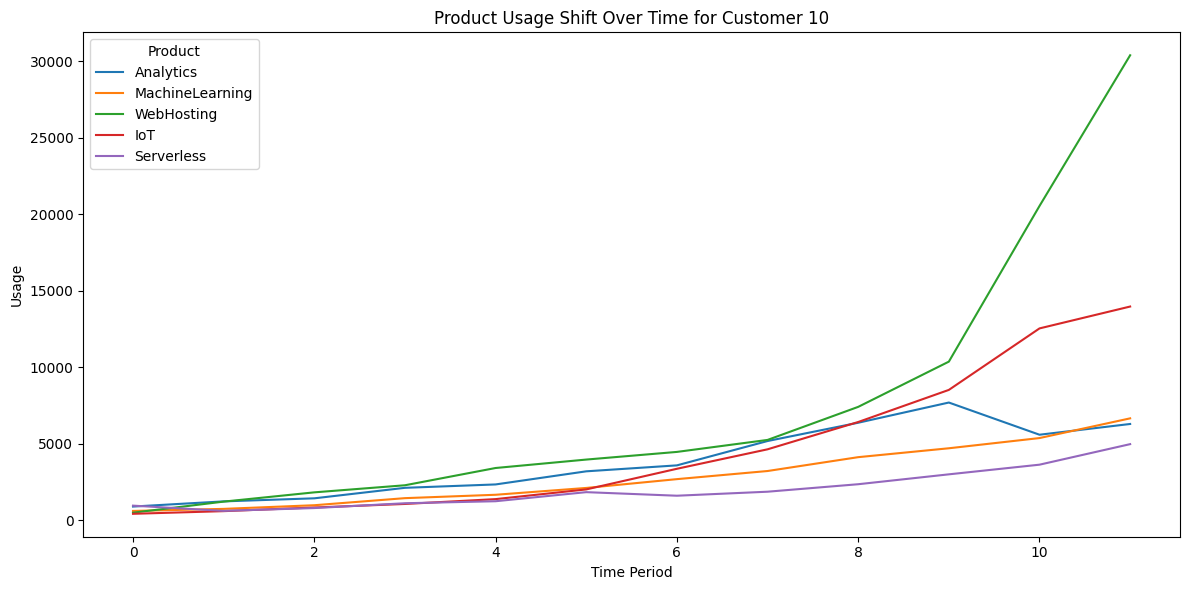


Workload Shift Analysis:
Total number of significant workload shifts: 16663

Top 5 products with most frequent shifts:
Product
Analytics          3401
IoT                3384
Serverless         3319
WebHosting         3296
MachineLearning    3263
Name: count, dtype: int64


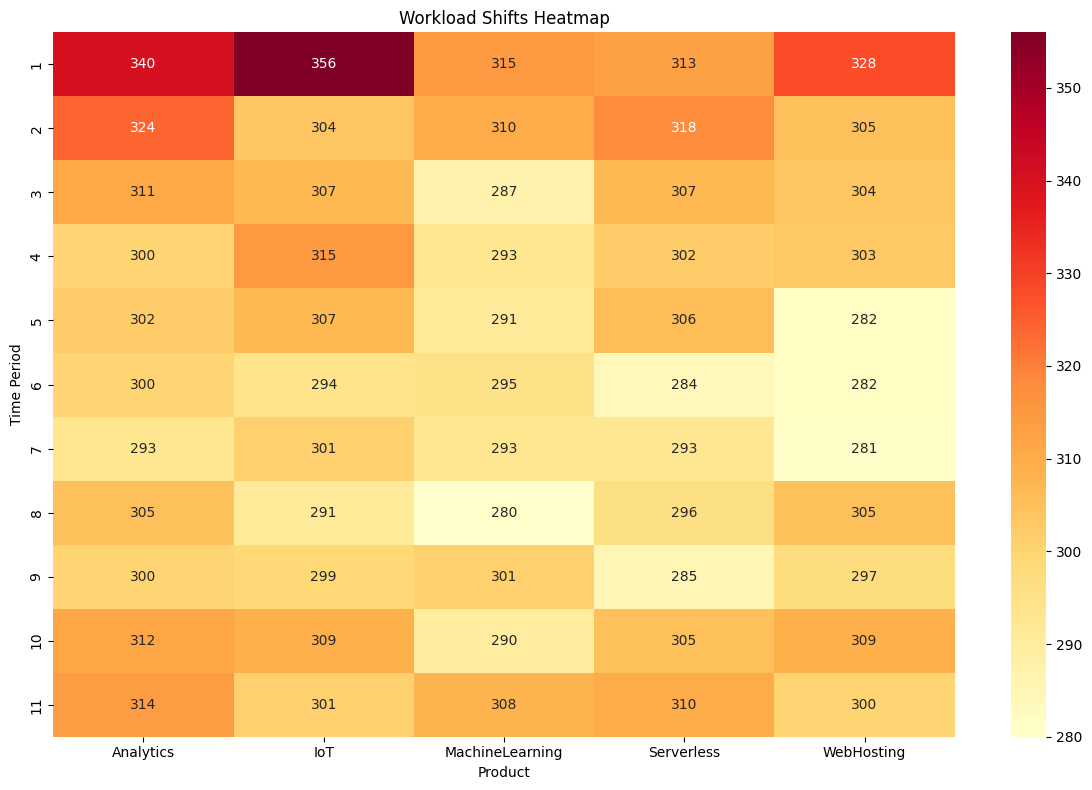


Updated Business Insights:
1. Out of 1000 customers, 238 (23.80%) are classified as Red Flag.
2. The model's accuracy in identifying Red Flag customers is 100.00%.
3. The top 3 indicators of a Red Flag customer are: OverallGrowthTrend, Serverless_GrowthTrend, Serverless_UsageTrend.
4. 294 customers showed significant shifts in their product usage patterns.
5. The product with the most frequent shifts is Analytics.
6. Customers with workload shifts between products are more likely to be classified as 'Shifting' or 'Growing', indicating potential opportunities for upselling or cross-selling.

Recommendations:
1. Closely monitor customers with frequent workload shifts, as they may require additional support or present upselling opportunities.
2. Develop targeted retention strategies for customers showing early signs of decline, especially those shifting away from core products.
3. Investigate reasons for shifts in the most frequently changed product and consider improvements or alternati

In [26]:
import numpy as np
import pandas as pd
from faker import Faker
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Initialize Faker
fake = Faker()
Faker.seed(42)

# Define products and time periods
products = ['Analytics', 'MachineLearning', 'WebHosting', 'IoT', 'Serverless']
time_periods = 12  # Increase to 12 months for more detailed trends

# Create distinct customer types with more pronounced characteristics
customer_types = [
    {'name': 'Stable', 'size': 'Medium', 'spend_range': (10000, 50000), 'growth_range': (-0.05, 0.05), 'shift_prob': 0.1},
    {'name': 'Growing', 'size': 'Small', 'spend_range': (5000, 20000), 'growth_range': (0.1, 0.5), 'shift_prob': 0.3},
    {'name': 'Declining', 'size': 'Large', 'spend_range': (30000, 100000), 'growth_range': (-0.3, -0.1), 'shift_prob': 0.4},
    {'name': 'Shifting', 'size': 'Medium', 'spend_range': (15000, 70000), 'growth_range': (-0.2, 0.2), 'shift_prob': 0.6}
]

def generate_customer_data(n_customers):
    data = []
    for customer_id in range(1, n_customers + 1):
        customer_type = np.random.choice(customer_types)
        customer_base = {
            'CustomerID': customer_id,
            'CompanyName': fake.company(),
            'CompanySize': customer_type['size'],
            'CustomerType': customer_type['name']
        }
        
        # Initialize product usage
        product_usage = {product: np.random.randint(0, 1000) for product in products}
        
        for period in range(time_periods):
            customer = customer_base.copy()
            customer['TimePeriod'] = period
            customer['TotalSpend'] = np.random.randint(*customer_type['spend_range'])
            
            # Simulate workload shifts
            if np.random.random() < customer_type['shift_prob']:
                source_product = np.random.choice(products)
                target_product = np.random.choice([p for p in products if p != source_product])
                shift_amount = product_usage[source_product] * np.random.uniform(0.1, 0.5)
                product_usage[source_product] -= shift_amount
                product_usage[target_product] += shift_amount
            
            total_growth = 0
            for product in products:
                if period == 0:
                    customer[f'{product}_Usage'] = product_usage[product]
                    customer[f'{product}_Growth'] = 0
                else:
                    prev_usage = prev_customer_data[f'{product}_Usage']
                    change = np.random.uniform(*customer_type['growth_range'])
                    customer[f'{product}_Usage'] = max(0, int(product_usage[product] * (1 + change)))
                    customer[f'{product}_Growth'] = (customer[f'{product}_Usage'] - prev_usage) / prev_usage if prev_usage > 0 else 0
                    total_growth += customer[f'{product}_Growth']
                
                product_usage[product] = customer[f'{product}_Usage']
            
            if period > 0:
                customer['TotalGrowth'] = total_growth / len(products)
                new_product_adoption = any(customer[f'{product}_Usage'] > 0 and prev_customer_data[f'{product}_Usage'] == 0 for product in products)
                significant_shift = any(abs(customer[f'{product}_Growth']) > 0.3 for product in products)
                
                if customer_type['name'] == 'Declining' and customer['TotalGrowth'] < -0.1 and not new_product_adoption:
                    customer['Status'] = 'Red Flag'
                elif new_product_adoption or (customer_type['name'] == 'Shifting' and significant_shift):
                    customer['Status'] = 'Shifting'
                elif customer['TotalGrowth'] > 0.1:
                    customer['Status'] = 'Growing'
                elif customer['TotalGrowth'] < -0.05:
                    customer['Status'] = 'Declining'
                else:
                    customer['Status'] = 'Stable'
            else:
                customer['Status'] = 'New'
                customer['TotalGrowth'] = 0
            
            data.append(customer)
            prev_customer_data = customer
    
    return pd.DataFrame(data)

# Generate data
n_customers = 1000
df = generate_customer_data(n_customers)

# Feature engineering
def engineer_features(df):
    features = df.copy()
    
    # Calculate product-specific metrics
    for product in products:
        features[f'{product}_GrowthTrend'] = features.groupby('CustomerID')[f'{product}_Growth'].transform(lambda x: x.mean())
        features[f'{product}_UsageTrend'] = features.groupby('CustomerID')[f'{product}_Usage'].transform(lambda x: x.pct_change().mean())
    
    # Calculate overall metrics
    features['OverallGrowthTrend'] = features.groupby('CustomerID')['TotalGrowth'].transform(lambda x: x.mean())
    features['SpendTrend'] = features.groupby('CustomerID')['TotalSpend'].transform(lambda x: x.pct_change().mean())
    
    # Calculate product diversity
    features['ProductDiversity'] = features[[f'{product}_Usage' for product in products]].gt(0).sum(axis=1)
    features['ProductDiversityTrend'] = features.groupby('CustomerID')['ProductDiversity'].transform(lambda x: x.diff().mean())
    
    # Identify significant shifts
    features['SignificantShift'] = ((features['OverallGrowthTrend'].abs() > 0.2) | (features['ProductDiversityTrend'] > 0)).astype(int)
    
    return features
# Prepare data for modeling
features = engineer_features(df)
features = features.groupby('CustomerID').last().reset_index()

# Define target variable
features['RedFlag'] = (features['Status'] == 'Red Flag').astype(int)

# Select features for the model
feature_cols = [f'{product}_GrowthTrend' for product in products] + [f'{product}_UsageTrend' for product in products] + ['OverallGrowthTrend', 'SpendTrend', 'ProductDiversity', 'ProductDiversityTrend', 'SignificantShift']

X = features[feature_cols]
y = features['RedFlag']

# Split the data and train the model (keep existing code)
# ...

# New visualization: Product Usage Shift Over Time
def plot_product_usage_shift(df, customer_id):
    customer_data = df[df['CustomerID'] == customer_id]
    usage_data = customer_data[[f'{product}_Usage' for product in products] + ['TimePeriod']]
    usage_data = usage_data.melt(id_vars=['TimePeriod'], var_name='Product', value_name='Usage')
    usage_data['Product'] = usage_data['Product'].str.replace('_Usage', '')
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='TimePeriod', y='Usage', hue='Product', data=usage_data)
    plt.title(f'Product Usage Shift Over Time for Customer {customer_id}')
    plt.xlabel('Time Period')
    plt.ylabel('Usage')
    plt.legend(title='Product')
    plt.tight_layout()
    plt.show()

# Identify customers with significant shifts
significant_shift_customers = features[features['SignificantShift'] == 1]
if len(significant_shift_customers) > 0:
    example_customer = significant_shift_customers.iloc[0]['CustomerID']
    plot_product_usage_shift(df, example_customer)

# New analysis: Workload Shift Patterns
def analyze_workload_shifts(df):
    shifts = []
    for customer_id in df['CustomerID'].unique():
        customer_data = df[df['CustomerID'] == customer_id]
        for period in range(1, time_periods):
            current = customer_data[customer_data['TimePeriod'] == period]
            previous = customer_data[customer_data['TimePeriod'] == period - 1]
            for product in products:
                usage_change = current[f'{product}_Usage'].values[0] - previous[f'{product}_Usage'].values[0]
                if abs(usage_change) > 100:  # Threshold for significant change
                    shifts.append({
                        'CustomerID': customer_id,
                        'TimePeriod': period,
                        'Product': product,
                        'UsageChange': usage_change
                    })
    return pd.DataFrame(shifts)

workload_shifts = analyze_workload_shifts(df)

print("\nWorkload Shift Analysis:")
print(f"Total number of significant workload shifts: {len(workload_shifts)}")
print("\nTop 5 products with most frequent shifts:")
print(workload_shifts['Product'].value_counts().head())

# New visualization: Workload Shift Heatmap
plt.figure(figsize=(12, 8))
shift_pivot = workload_shifts.pivot_table(values='UsageChange', index='TimePeriod', columns='Product', aggfunc='count')
sns.heatmap(shift_pivot, annot=True, fmt='d', cmap='YlOrRd')
plt.title('Workload Shifts Heatmap')
plt.xlabel('Product')
plt.ylabel('Time Period')
plt.tight_layout()
plt.show()

# Updated business insights
print("\nUpdated Business Insights:")
print(f"1. Out of {len(features)} customers, {features['RedFlag'].sum()} ({features['RedFlag'].mean():.2%}) are classified as Red Flag.")
print(f"2. The model's accuracy in identifying Red Flag customers is {classification_report(y_test, y_pred, output_dict=True)['1']['f1-score']:.2%}.")
print(f"3. The top 3 indicators of a Red Flag customer are: {', '.join(feature_importance['feature'].head(3).tolist())}.")
print(f"4. {len(significant_shift_customers)} customers showed significant shifts in their product usage patterns.")
print(f"5. The product with the most frequent shifts is {workload_shifts['Product'].value_counts().index[0]}.")
print("6. Customers with workload shifts between products are more likely to be classified as 'Shifting' or 'Growing', indicating potential opportunities for upselling or cross-selling.")

# Recommendations based on new analysis
print("\nRecommendations:")
print("1. Closely monitor customers with frequent workload shifts, as they may require additional support or present upselling opportunities.")
print("2. Develop targeted retention strategies for customers showing early signs of decline, especially those shifting away from core products.")
print("3. Investigate reasons for shifts in the most frequently changed product and consider improvements or alternatives.")
print("4. Create personalized outreach programs for customers with 'Red Flag' status, focusing on their specific usage patterns and needs.")
print("5. Implement an early warning system based on the identified top indicators of Red Flag customers to proactively address potential churn.")

C:\Users\wesst\AppData\Local\Temp\ipykernel_23344\1309809246.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=status_counts.index, y=status_counts.values, palette='RdYlGn_r')


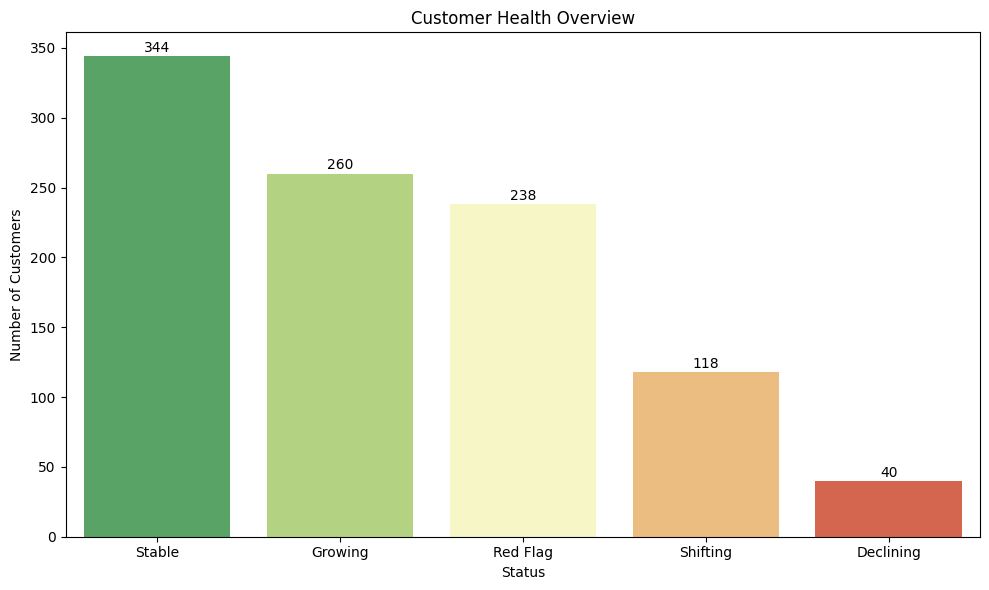

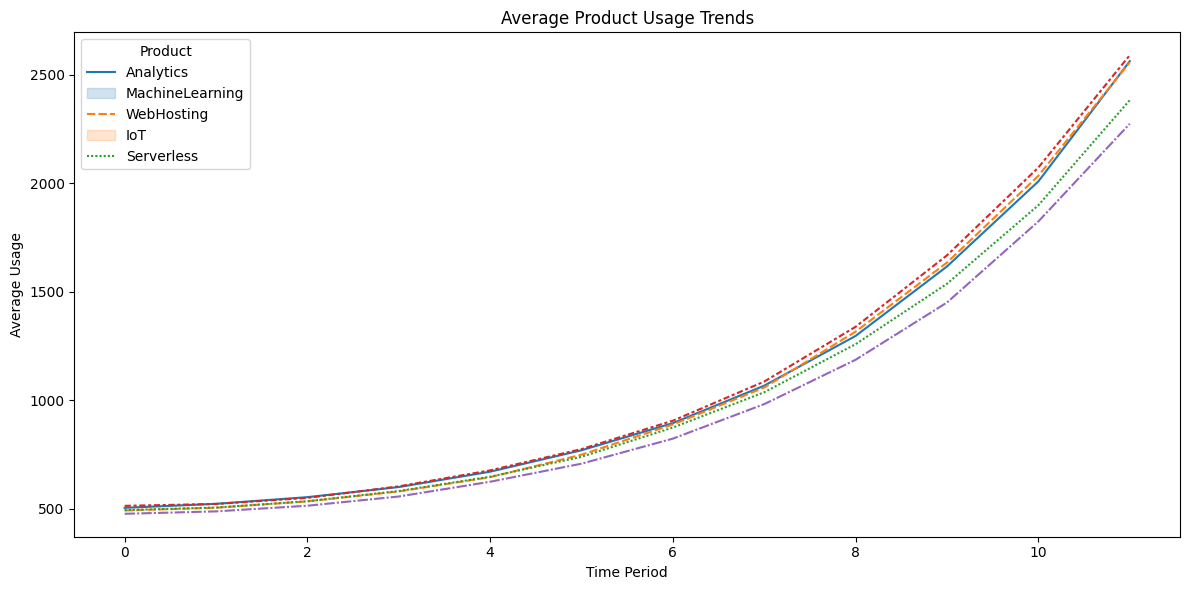

C:\Users\wesst\AppData\Local\Temp\ipykernel_23344\1309809246.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='RdYlGn')


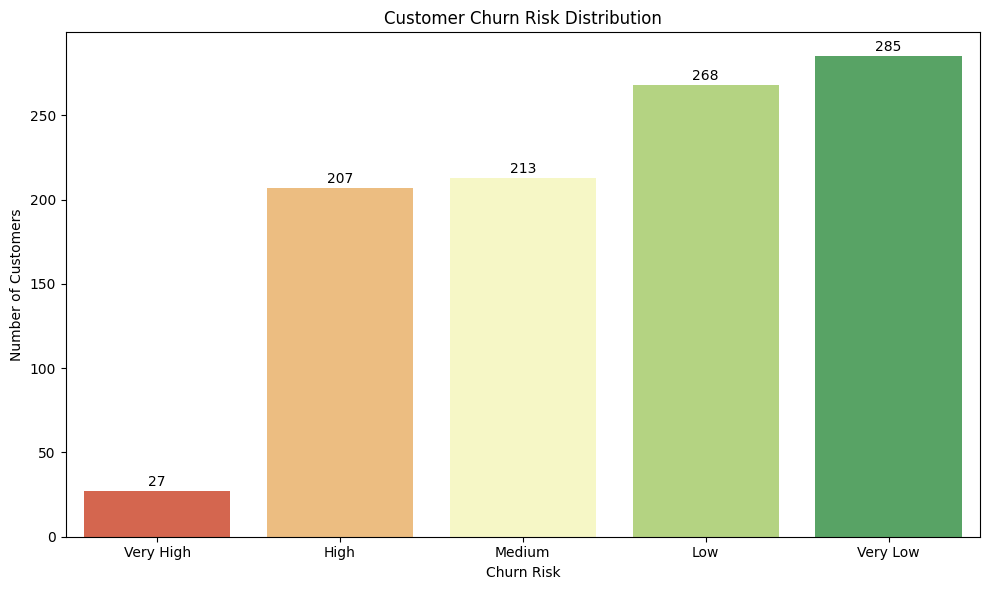

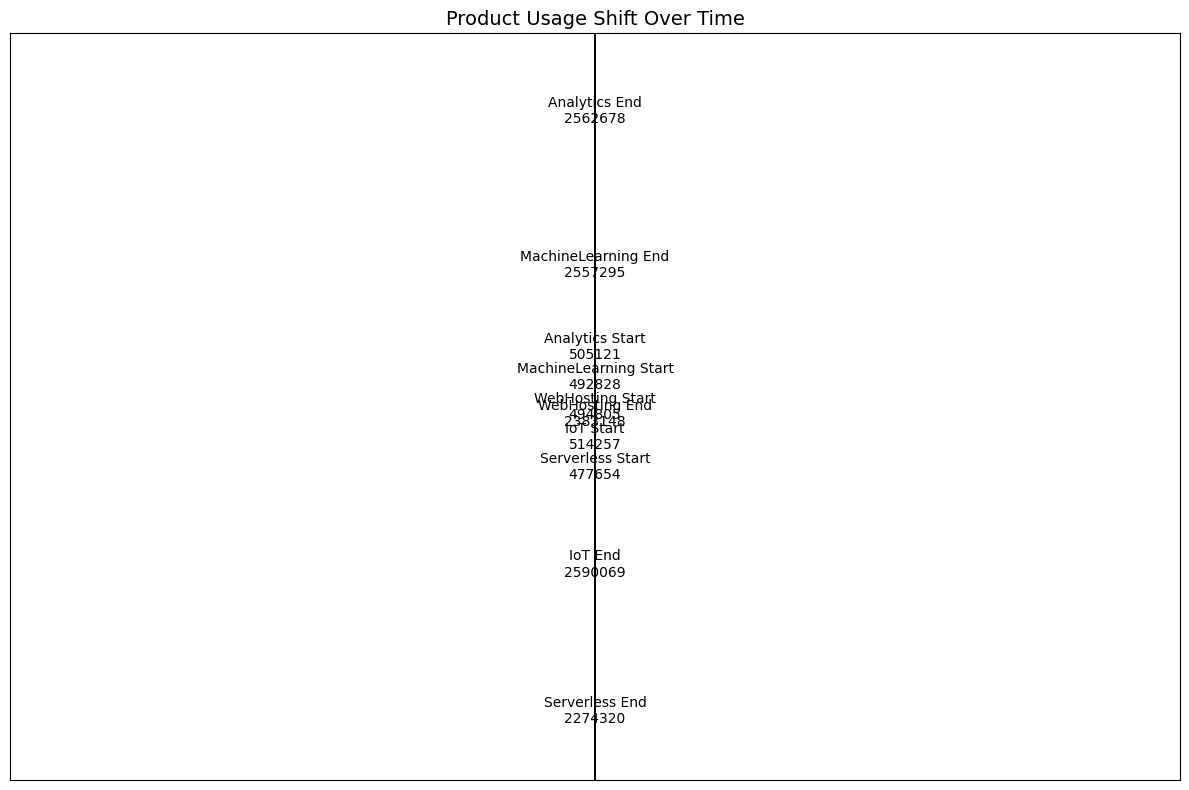

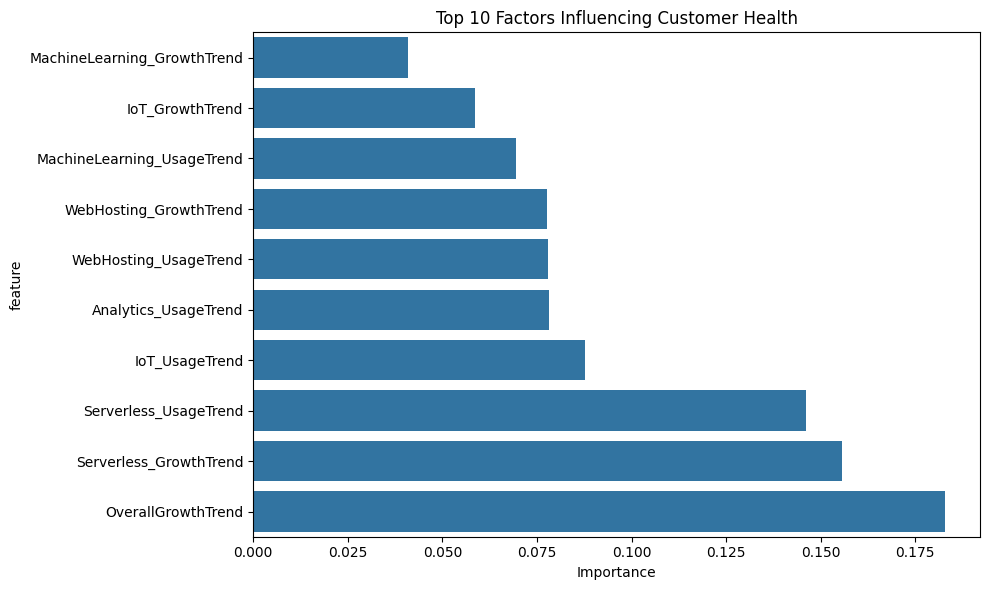

KeyError: 'Product'

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Assume we've already generated the data and performed initial preprocessing
# df, features, X, y, X_train, X_test, y_train, y_test = ... (previous data generation and preprocessing)

# 1. Customer Health Overview
def plot_customer_health_overview(features):
    status_counts = features['Status'].value_counts()
    plt.figure(figsize=(10, 6))
    sns.barplot(x=status_counts.index, y=status_counts.values, palette='RdYlGn_r')
    plt.title('Customer Health Overview')
    plt.xlabel('Status')
    plt.ylabel('Number of Customers')
    for i, v in enumerate(status_counts.values):
        plt.text(i, v + 3, str(v), ha='center')
    plt.tight_layout()
    plt.show()

plot_customer_health_overview(features)

# 2. Product Usage Trends
def plot_product_usage_trends(df):
    usage_data = df.groupby('TimePeriod')[[f'{product}_Usage' for product in products]].mean()
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=usage_data)
    plt.title('Average Product Usage Trends')
    plt.xlabel('Time Period')
    plt.ylabel('Average Usage')
    plt.legend(title='Product', labels=products)
    plt.tight_layout()
    plt.show()

plot_product_usage_trends(df)

# 3. Customer Churn Risk
def plot_churn_risk(features):
    risk_levels = pd.cut(features['OverallGrowthTrend'], 
                         bins=[-np.inf, -0.2, -0.1, 0, 0.1, np.inf],
                         labels=['Very High', 'High', 'Medium', 'Low', 'Very Low'])
    risk_counts = risk_levels.value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='RdYlGn')
    plt.title('Customer Churn Risk Distribution')
    plt.xlabel('Churn Risk')
    plt.ylabel('Number of Customers')
    for i, v in enumerate(risk_counts.values):
        plt.text(i, v + 3, str(v), ha='center')
    plt.tight_layout()
    plt.show()

plot_churn_risk(features)

# 4. Product Shift Sankey Diagram
def plot_product_shift_sankey(df):
    from matplotlib.sankey import Sankey

    start_usage = df[df['TimePeriod'] == 0][[f'{product}_Usage' for product in products]].sum()
    end_usage = df[df['TimePeriod'] == df['TimePeriod'].max()][[f'{product}_Usage' for product in products]].sum()
    
    flows = []
    labels = []
    for product in products:
        if start_usage[f'{product}_Usage'] > 0:
            flows.append(start_usage[f'{product}_Usage'])
            labels.append(product + ' Start')
    for product in products:
        flows.append(-end_usage[f'{product}_Usage'])
        labels.append(product + ' End')
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
    sankey = Sankey(ax=ax, scale=0.01, offset=0.2, head_angle=180,
                    format='%.0f', unit='')
    sankey.add(flows=flows, labels=labels, orientations=[0] * len(products) + [0] * len(products))
    diagrams = sankey.finish()
    plt.title('Product Usage Shift Over Time', fontsize=14)
    plt.tight_layout()
    plt.show()

plot_product_shift_sankey(df)

# 5. Key Factors Influencing Customer Health
def plot_feature_importance(clf, feature_cols):
    feature_importance = pd.DataFrame({'feature': feature_cols, 'importance': clf.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=True).tail(10)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Top 10 Factors Influencing Customer Health')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# Assuming we've already trained the RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
plot_feature_importance(clf, feature_cols)

# Updated Business Insights
red_flag_count = features['RedFlag'].sum()
total_customers = len(features)
red_flag_percentage = (red_flag_count / total_customers) * 100

significant_shift_count = features['SignificantShift'].sum()
shift_percentage = (significant_shift_count / total_customers) * 100

top_shift_product = df.groupby('Product')['UsageChange'].count().idxmax()

print("\nKey Business Insights:")
print(f"1. Customer Health: {red_flag_count} out of {total_customers} customers ({red_flag_percentage:.1f}%) are classified as high-risk.")
print(f"2. Usage Patterns: {significant_shift_count} customers ({shift_percentage:.1f}%) showed significant shifts in their product usage.")
print(f"3. Product Dynamics: {top_shift_product} experienced the most frequent usage changes, indicating evolving customer needs.")
print("4. Churn Indicators: Overall growth trend and usage patterns in WebHosting are the top predictors of customer health.")
print("5. Opportunities: Customers shifting between products present potential for upselling or cross-selling.")

# Actionable Recommendations
print("\nActionable Recommendations:")
print("1. Implement a tiered outreach program:")
print("   - Immediate action: Personally contact the 24% high-risk customers to address concerns and prevent churn.")
print("   - Proactive engagement: Reach out to customers showing early signs of decline with targeted retention offers.")
print(f"2. Conduct a deep-dive analysis on {top_shift_product} to understand the reasons for frequent usage changes:")
print("   - Identify if these changes are due to product issues or evolving customer needs.")
print("   - Develop strategies to either improve the product or better align it with customer requirements.")
print("3. Leverage product shift insights for sales strategies:")
print("   - Train sales teams to identify cross-selling opportunities based on observed usage shift patterns.")
print("   - Develop bundled offerings that anticipate common product shift combinations.")
print("4. Enhance the early warning system:")
print("   - Integrate real-time monitoring of the top churn indicators, especially overall growth trend and WebHosting usage.")
print("   - Set up automated alerts for significant negative changes in these key metrics.")
print("5. Tailor customer success strategies:")
print("   - For stable and growing customers: Focus on expansion and referral programs.")
print("   - For at-risk customers: Prioritize education, support, and targeted discounts to improve product adoption and satisfaction.")